In [8]:
%reload_ext autoreload

In [9]:
# Imports

%load_ext autoreload
%autoreload 2

%matplotlib inline
import numpy as np
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt

from fastai.imports import *
from fastai.structured import *
from matplotlib import pyplot
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.metrics import f1_score,\
    accuracy_score, confusion_matrix,\
    precision_score, recall_score,\
    roc_curve, roc_auc_score,\
    cohen_kappa_score, mean_absolute_error,\
    precision_recall_curve, auc,\
    average_precision_score

set_plot_sizes(12,14,16)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import csv

sys.path.append('../lib')
import utils
import preprocessing

In [11]:
# Load in data

PATH = "../data/"
df_raw = pd.read_csv(f'{PATH}churn.csv', low_memory=False, 
                     parse_dates=['canceldate', 'licence_registration_date', 'golive_date'])

df_raw = df_raw.drop(columns=['Username*', 'Bill Company', 'Cancellation Date',
       'Neto License Registration Date', 'Days Active', 'Neto License Status',
       'Cancellation Reason', 'Cancellation Details', 'Team Assignment',
       'Vertical', 'License Plans', 'License Plan',
       'Cancellation - Changing Platforms?', 'Cancellation - New Platform',
       'Salesperson', 'Go Live Date', 'Neto Host URL', 'golive_date', 'golive_days'])

# Delete rubbish rows
rubbish_urls = ['tobias-tattoo-a.neto.com.au', 'www.lovesongs.com.au', 'vantage-demo.neto.com.au', 'marshall.neto.com.au']

for url in rubbish_urls:
    loc = df_raw[df_raw.url == url].index[0]
    df_raw = df_raw.drop([loc], axis=0)
    
# Delete rubbish usernames
rubbish_usernames = ['rCKGN1JlpnRssbH', 'c8kLmHScrYaUKAz']

for username in rubbish_usernames:
    loc = df_raw[df_raw.username == username].index[0]
    df_raw = df_raw.drop([loc], axis=0)

In [6]:
print(len(df_raw.loc[df_raw.churned == 0]), df_raw.loc[df_raw.churned == 0].shape)

df_processed = preprocessing.prepare_data(df_raw.loc[(df_raw.licence_status != "STAGING") & (df_raw.licence_status != "PARTNER") & (df_raw.plan != "CUSTOM") & (df_raw.plan != "TRIAL")])
print(len(df_processed), df_processed.shape)

2646 (2646, 26)
Sorting dataframe by licence_registration_date ...
Defaulting last_login_days for missing values to the plans mean or platform medeian ...
  Platform last_login_days median: 7.0
  Platform last_login_days mean: 12.464120856063785
  List records that still have NaN in them ...
  0
Defaulting all NaN values with median ...
Binning last_login_days
week         3932
month+        754
month         654
fortnight     476
day           169
few_days        0
Name: last_login_categories, dtype: int64
Binning NPS data
Fixing days_active abnormal values ...
One-hot encoding customer_account_status
One-hot encoding plan
One-hot encoding nps
One-hot encoding last_login_categories
Preprocessing dates ...
Dropping feature customer_account_status_Good ...
Dropping feature last_login_days ...
Dropping feature account_status ...
Dropping feature canceldate ...
Dropping feature url ...
Dropping feature total_churn_concern_cases_age ...
Dropping features with 'interactions' in their name .

In [7]:
print(len(df_processed), df_processed.shape)
#df_processed = df_processed.loc[df_processed.licence_status == "LIVE"]
df_processed = df_processed.drop(columns=['licence_status'])
print(len(df_processed), df_processed.shape)

5985 (5985, 89)
2391 (2391, 88)


In [56]:
print(len(df_processed), df_processed.shape)

# filters LIVE customers
#df_filtered = df_processed.loc[df_processed.churned == 0]

df_data, y_data, nas = proc_df(df_processed, 'churned')
print(len(df_data), df_data.shape, nas)

2391 (2391, 88)
2391 (2391, 94) {'days_active': 948.0, 'licence_registration_Year': 2017.0, 'licence_registration_Month': 6.0, 'licence_registration_Week': 26.0, 'licence_registration_Day': 19.0, 'licence_registration_Dayofweek': 2.0, 'licence_registration_Dayofyear': 182.0}


In [57]:
# this is where we "checkout" our latest model, likely done at container build time
joblib_file = "churn_model.pkl"

# Load from file
churn_model = joblib.load(joblib_file)

In [58]:
predictions = churn_model.predict(df_data)
probability = churn_model.predict_proba(df_data)[:,1]
len(probability), len(predictions), len(df_filtered)

ValueError: Number of features of the model must match the input. Model n_features is 97 and input n_features is 94 

In [87]:
df_predictions = pd.DataFrame(predictions)
df_probability = pd.DataFrame(probability)

In [88]:
#df_output = df_processed[df_processed.churned == 0].copy()
#df_output = df_processed[df_processed.churned == 0].copy()

In [89]:
#df_output['prediction'] = predictions
#df_output['probability'] = probability
#df_output.prediction, y_data

df_data['prediction'] = predictions
df_data['probability'] = probability

accuracy_score(y_data,df_data['prediction'])

#len(y_data), len(df_data['prediction'])
#y_data[:20], df_data
#df_data[y_data != df_data.prediction]

0.934001670843776

In [39]:
# Calculate churn concern %
churn_concern_count = len(df_output.loc[df_output['prediction'] == 1])
total_active = len(df_output)
churn_concern_percent = round((churn_concern_count / total_active) * 100, 2)
print(f"Churn concern count: {churn_concern_count} of {total_active} ({churn_concern_percent}%)")

Churn concern count: 111 of 2391 (4.64%)


In [40]:
# Sort churn concerns by probability
df_sorted = df_output.loc[df_output['prediction'] == 1].sort_values(by=['probability'], ascending=False)

In [41]:
#df_output.annual_revenue_log.var(), df_output.annual_revenue_log.skew(), df_output.annual_revenue_log.mad(), df_output.annual_revenue_log.mode()



In [42]:
import time
seconds = time.time()

wandb.init(project="neto-customer-churn", name=f"customer_inference_{int(seconds)}")

now = datetime.datetime.now()

record_count = len(df_sorted.loc[df_sorted['probability'] > 0.0])
print(record_count)

array = []
for i in range(record_count):
#for i in range(len(df_sorted)):
    output_string = f"{now},{df_sorted.username.iloc[i]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].url.iloc[0]},{df_raw[df_raw.username == df_sorted.username.iloc[i]].plan.iloc[0]},{df_sorted.licence_registration_Year.iloc[i]},{df_sorted.probability.iloc[i]}"
    print(output_string)
    array.append(output_string)

wandb.config.inference_output = array

    #with open('../data/predictions.csv', 'w') as writeFile:
    #    writer = csv.writer(writeFile)
    #    writer.writerows(sorted_array)

#writeFile.close()

111
2019-11-02 11:09:55.449393,N007510,dev-spotlightmy.neto.com.au,STANDARD,nan,0.8874524737501477
2019-11-02 11:09:55.449393,N063244,www.bobcases.com.au,PLAN-S-19Q1,2019.0,0.7812188739703486
2019-11-02 11:09:55.449393,N062467,grabz.co.nz,PLAN-360-19Q1,2019.0,0.7527207972968185
2019-11-02 11:09:55.449393,N054156,adtrade.neto.com.au,PLAN-S-19Q1,2019.0,0.747029535180295
2019-11-02 11:09:55.449393,N053125,picknpack-demo.neto.com.au,PLAN-L,nan,0.7461119860539023
2019-11-02 11:09:55.449393,N061656,www.gtmallusa.com,PLAN-L-US,2019.0,0.7309812145279235
2019-11-02 11:09:55.449393,N065324,www.barbecuemafia.com.au,PLAN-M-19Q1,2019.0,0.7306691016750588
2019-11-02 11:09:55.449393,N040293,www.chilliandwillow.com.au,PLAN-S-17Q2,2017.0,0.7301173886887586
2019-11-02 11:09:55.449393,N052071,myob.neto.com.au,PLAN-360-17Q2,nan,0.7175220366155368
2019-11-02 11:09:55.449393,N063884,www.prestigetyreandauto.com.au,PLAN-360-19Q1,2019.0,0.7162544618275887
2019-11-02 11:09:55.449393,N062429,www.tomscap.com.au,P

In [15]:
n_number = 'N063157'
utils.display_all(df_filtered[df_filtered.username == n_number])

,username,days_active,cases_total,cases_open,cases_closed,cases_age_hours_total,cases_age_hours_average,churned,plan_not_set,cases_total_was_nan,cases_open_was_nan,cases_closed_was_nan,cases_age_hours_total_was_nan,cases_age_hours_average_was_nan,days_active_modified,customer_account_status_PoorStanding,plan_BASIC,plan_BRONZE,plan_BUSINESS,plan_BUSINESS +,plan_BUSINESS ONE,plan_CUSTOM XL,plan_ENTERPRISE,plan_GOLD,plan_GROW,plan_L&S - PREMIUM,plan_L&S - STANDARD,plan_L&S - ULTIMATE,plan_LIST N SEND SILVER,plan_LISTNSEND,plan_NETO XL,plan_NETO XXL,plan_PLAN-360-17Q2,plan_PLAN-360-19Q1,plan_PLAN-360-TRANSITION,plan_PLAN-360-US,plan_PLAN-L,plan_PLAN-L-17Q2,plan_PLAN-L-19Q1,plan_PLAN-L-US,plan_PLAN-M,plan_PLAN-M-17Q2,plan_PLAN-M-19Q1,plan_PLAN-M-US,plan_PLAN-S,plan_PLAN-S-17Q2,plan_PLAN-S-19Q1,plan_PLAN-S-US,plan_PLAN-XL-19Q1,plan_PLAN-XS,plan_PLAN-XS-17Q2,plan_PREMIER,plan_PREMIUM,plan_SILVER,plan_STANDARD,plan_START,plan_START - LEGACY,plan_TELSTRA - ONLINE STORE M,plan_TELSTRA - ONLINE STORE S,plan_TELSTRA - POS S,plan_TELSTRA - PREMIUM,plan_TELSTRA - STANDARD,plan_ULTIMATE,plan_ULTIMATE PLUS,plan_no_plan,nps_no_data,nps_detractor,nps_passive,nps_promoter,last_login_categories_day,last_login_categories_few_days,last_login_categories_week,last_login_categories_fortnight,last_login_categories_month,last_login_categories_month+,licence_registration_Year,licence_registration_Month,licence_registration_Week,licence_registration_Day,licence_registration_Dayofweek,licence_registration_Dayofyear,licence_registration_Is_month_end,licence_registration_Is_month_start,licence_registration_Is_quarter_end,licence_registration_Is_quarter_start,licence_registration_Is_year_end,licence_registration_Is_year_start,licence_registration_Elapsed
6227,N063157,221.0,7,0,0,3142,448,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,2019.0,3.0,13.0,25.0,0.0,84.0,False,False,False,False,False,False,1553472000


In [16]:
from eli5 import show_prediction
loc_address = df_filtered[df_filtered.username == n_number].index[0]
show_prediction(churn_model, df_data.loc[loc_address], show_feature_values=True)

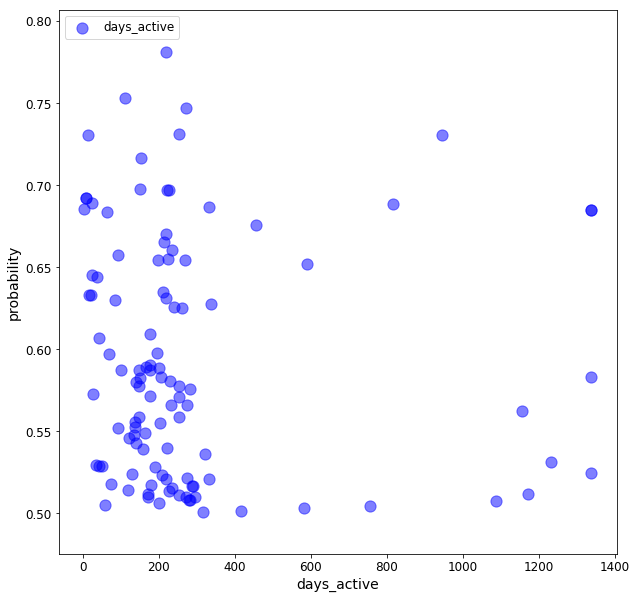

In [23]:
feature1='days_active'
feature2='probability'

plt.figure(figsize=(10,10))
plt.scatter(df_sorted[feature1], df_sorted[feature2],
            c='b', marker='.', label=feature1,
            s=500, alpha=.5)

plt.legend(loc='upper left')
plt.xlabel(feature)
plt.ylabel(feature2)

plt.show()

TypeError: nan is not a string

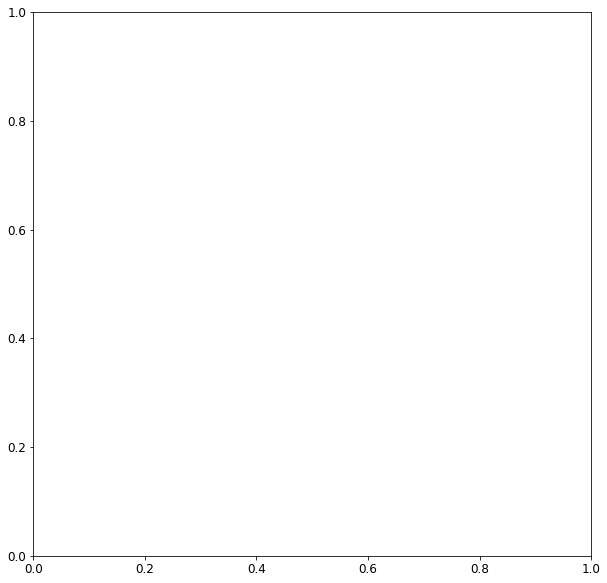

In [33]:
feature='last_login_categories'

plt.figure(figsize=(10,10))
plt.scatter(df_sorted[feature], df_sorted['probability'],
            c='b', marker='.', label=feature,
            s=500, alpha=.5)

plt.legend(loc='upper left')
plt.xlabel(feature)
plt.ylabel("probability")

plt.show()

In [17]:
print(df_sorted[feature].mode())

0    136
1    208
dtype: int64


In [18]:
def general_stats(df, feature):
    array = utils.data_summary_feature(df, feature)
    print(array[0])
    print("")
    count = 1
    for heading in ['Min', 'Max', 'Mean', 'Trimmed Mean', 'Median', 'Mode', 'Std', 'CV']:
        print(f"{heading}: {array[count]}")
        count += 1
        
general_stats(df_sorted,feature)

days_active

Min: 52
Max: 1705
Mean: 457.95454545454544
Trimmed Mean: 381.30555555555554
Median: 252.0
Mode: 0    136
1    208
dtype: int64
Std: 460.1027162642512
CV: 1.0046907948202013
